In [38]:
import spacy

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
import hdbscan
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

import string
import time
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
from bs4 import BeautifulSoup
import numpy as np

import ElasticSearchClass
import importlib
importlib.reload(ElasticSearchClass)

<module 'ElasticSearchClass' from 'E:\\my_study_place\\python\\jupyter\\spacy\\ElasticSearchClass.py'>

In [115]:
def load20NewsGroups():
    # #############################################################################
    # Load some categories from the training set
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
     ]
    dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)
    print("%d documents" % len(dataset.data))
    print("%d categories" % len(dataset.target_names))
    return dataset.data

In [2]:
def loadStackoverflowFromES():
    esUtil = ElasticSearchClass.ElasticSearchClass("192.168.18.187", 9201)
    dsl = '''
    {
    "_source":["title", "body"],
    "query":{
        "bool":{
            "must":{
                "match":{"posttypeid":1}}
            }
        },
    "size":1
    }
    '''
    res = esUtil.search(indexName="stackoverflow", body=dsl)
    for doc in res['hits']['hits']:
         print("%s) %s" % (doc['_id'], doc['_source']))
    
def iterLoadStackoverflowFromES():
    esUtil = ElasticSearchClass.ElasticSearchClass("192.168.18.187", 9201)
    dsl = '''
    {
    "_source":["body"],
    "query":{
        "bool":{
            "must":{
                "match":{"posttypeid":1}}
            }
        }
    }
    '''
    res = esUtil.scrollSearch(indexName="stackoverflow", body=dsl)
    print(res)
    count = 0
    data = []
    for doc in res:
        if count > 10000:
            break
        count += 1
        data.append([doc['_id'], doc['_source']['body']])
        #print(doc['_id'], doc['_source']['body'])
    return data
            
#loadStackoverflowFromES()
start_time = time.time()
data = iterLoadStackoverflowFromES()
end_time = time.time()
print("Retrieved {} records in {} Seconds".format(len(data), end_time - start_time))
#Retrieved 101 records in 1.3270199298858643 Seconds
#10001 records in 246.03912162780762 Seconds

<generator object scan at 0x000002DC40771620>
Retrieved 1092 records in 0.630699634552002 Seconds


In [17]:
###########create data clearner

#Custom transformer using spaCy 
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
   #some data will raise NotImplementedError: subclasses of ParserBase must override error()
    try:
        bs = BeautifulSoup(text, "html.parser")
        #code = [s.extract() for s in bs('code')]
        # replace other HTML symbols
        text = bs.get_text()
    except Exception as e:
        #print(e)
        pass
    text = text.lower()
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    # replace @xxxx with @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@mention", text)
    # here we don't need @mention
    text = re.sub("@mention", '', text).strip()
    # delete numbers
    text = re.sub(r'\w*\d\w*', '', text).strip()
    return text

In [25]:
############create tokenizer

#Create spacy tokenizer that parses a sentence and generates tokens
#these can also be replaced by word vectors 
# List of symbols we don't care about
punctuations = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "--", "//", "div"]
parser = spacy.load('en')
def tokenizeText(sentence):
    tokens = parser(sentence)
    #only keep nouns
    tokens = [tok for tok in tokens if (tok.tag_ in ("NN", "NNS", "NNP", "NNPS", "JJ"))]
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    #remove tokens lenth is 1
    tokens = [tok for tok in tokens if (len(tok)>1)]
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    return tokens

In [26]:
##########Create preprocess pipline and run
def preProcessData(X_train, max_features=None):
    #create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
    #vectorizer = TfidfVectorizer(tokenizer = tokenizeText)
    #svd = TruncatedSVD(2)
    #normalizer = Normalizer(copy=False)
    #removed any word that appeared in more than 70% of documents.
    #removed any word that appeared in less than 5 documents
    vectorizer = CountVectorizer(tokenizer = tokenizeText, min_df=5, max_df = 0.6, max_features=max_features)
    start_time = time.time()
    pipe_preprocess = Pipeline([("cleaner", CleanTextTransformer()),
                 ("vectorizer", vectorizer)])
    X_train_preprocess = pipe_preprocess.fit_transform(X_train)
    end_time = time.time()
    print("Preprocess done in {} Seconds".format(end_time - start_time))
    return X_train_preprocess, vectorizer

In [116]:
X_train = load20NewsGroups()
X_train_preprocess, vectorizer = preProcessData(X_train, 1000)

3387 documents
4 categories
Preprocess done in 237.4716272354126 Seconds


In [27]:
#print(data[1])
X_train = [row[1] for row in data]
print(X_train[1])
#print(cleanText(X_train[1]))
X_train_preprocess, vectorizer = preProcessData(X_train, 1000)
print(X_train_preprocess[:2])

<p>What is the "purist" or "correct" way to access an object's properties from within an object method that is not a getter/setter method?</p>

<p>I know that from outside of the object you should use a getter/setter, but from within would you just do:</p>

<p>Java:</p>

<pre><code>String property = this.property;
</code></pre>

<p>PHP:</p>

<pre><code>$property = $this-&gt;property;
</code></pre>

<p>or would you do:</p>

<p>Java:</p>

<pre><code>String property = this.getProperty();
</code></pre>

<p>PHP:</p>

<pre><code>$property = $this-&gt;getProperty();
</code></pre>

<p>Forgive me if my Java is a little off, it's been a year since I programmed in Java...</p>

<p><strong>EDIT:</strong></p>

<p>It seems people are assuming I am talking about private or protected variables/properties only. When I learned OO I was taught to use getters/setters for every single property even if it was public (and actually I was told never to make any variable/property public). So, I may be starting o

In [28]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=100,
                                learning_method='online',
                                batch_size=20,
                                random_state=125)
lda.fit(X_train_preprocess)

LatentDirichletAllocation(batch_size=20, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=125,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [29]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [30]:
feature_names = vectorizer.get_feature_names()
print_top_words(lda, feature_names, 20)

Topic #0:
class object method type public code property java new key php value way document python variable interface little static private
Topic #1:
thread site possible programming language experience email html developer .net good unit google advice answer response general word map apache
Topic #2:
table server database sql datum tool query studio visual column way row project software company linux mysql development new issue
Topic #3:
code number int bit time good people question byte free long kind output lot thing loop easy sort reference memory
Topic #4:
page library current standard array color level content api code algorithm new value point correct port tag template problem implementation
Topic #5:
string example list way case function true solution answer result item location character node end group search select expression statement
Topic #6:
function javascript xml var parameter new linq day browser firefox date work return bar framework html flash hour space tab
Topic #

In [50]:
##visualize doc_topic_distr
#https://de.dariah.eu/tatom/topic_model_visualization.html
def visDocTopicDist(doctopic):
    #N documents, K topics
    N, K = doctopic.shape
    ind = np.arange(N)
    width = 0.5
    height_cumulative = np.zeros(N)
    plots=[]
    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, doctopic[:, k], width, color=color)
        else:
            p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += doctopic[:, k]
        plots.append(p)
    plt.ylim(0,1)
    plt.ylabel('Topics')
    plt.title('Topics in docs')
    plt.xticks(ind+width/2, [n for n in range(N)])
    plt.yticks(np.arange(0,1,10))
    topic_labels=['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels)
    plt.show()

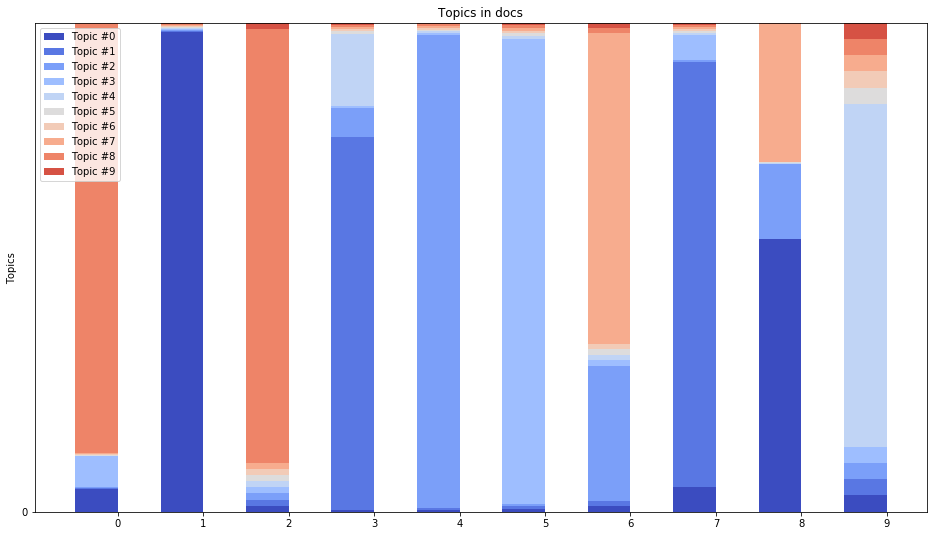

(10, 10)
['19', '<p>Solutions are welcome in any language. :-) I\'m looking for the fastest way to obtain the value of π, as a personal challenge. More specifically I\'m using ways that don\'t involve using <code>#define</code>d constants like <code>M_PI</code>, or hard-coding the number in.</p>\n\n<p>The program below tests the various ways I know of. The inline assembly version is, in theory, the fastest option, though clearly not portable; I\'ve included it as a baseline to compare the other versions against. In my tests, with built-ins, the <code>4 * atan(1)</code> version is fastest on GCC 4.2, because it auto-folds the <code>atan(1)</code> into a constant. With <code>-fno-builtin</code> specified, the <code>atan2(0, -1)</code> version is fastest.</p>\n\n<p>Here\'s the main testing program (<code>pitimes.c</code>):</p>\n\n<pre class="lang-c prettyprint-override"><code>#include &lt;math.h&gt;\n#include &lt;stdio.h&gt;\n#include &lt;time.h&gt;\n\n#define ITERS 10000000\n#define TEST

In [51]:
#get document_topic_distribution
doc_topic_distr = lda.transform(X_train_preprocess[:10])
visDocTopicDist(doc_topic_distr)
print(doc_topic_distr.shape)
print(data[0])
print(doc_topic_distr[0])

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
#https://github.com/bmabey/pyLDAvis/issues/69
visData = pyLDAvis.sklearn.prepare(lda, X_train_preprocess, vectorizer, mds='mmds')
pyLDAvis.show(visData,  ip="127.0.0.1", port=8889)

D:\Program_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [14/Mar/2018 10:32:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2018 10:32:19] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2018 10:32:19] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2018 10:32:19] "GET /LDAvis.js HTTP/1.1" 200 -
